In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [5]:
import scanpy as sc 
import sys 
sys.path.append('../../src')

from spaceoracle.prophets import Prophet

2025-01-06 16:41:58.396888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
adata_train = sc.read_h5ad(
    '/ix/djishnu/shared/djishnu_kor11/training_data/survey_kidney.h5ad')

adata_train.shape

(6959, 3000)

In [7]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

Matplotlib is building the font cache; this may take a moment.


In [8]:
import pickle

with open('/ix/djishnu/shared/djishnu_kor11/training_data/kidney_celloracle.pkl', 'rb') as f:
    oracle = pickle.load(f)

In [10]:
oracle.adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster_cat'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators', 'isin_actve_regulators'
    uns: 'dimred_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'diffmap_evals', 'paga', 'ct2_sizes', 'ct2_colors', '

In [12]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="ct2", alpha=10,
                         verbose_level=10)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for B...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for DC...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Anti-Apoptosis...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_Capilary...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Endothelial_DVR...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Epithelial_Collecting_Duct...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Granulocyte...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for Mac...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for T...


  0%|          | 0/2295 [00:00<?, ?it/s]

CPU times: user 31min 28s, sys: 7.11 s, total: 31min 36s
Wall time: 37min 19s


In [13]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

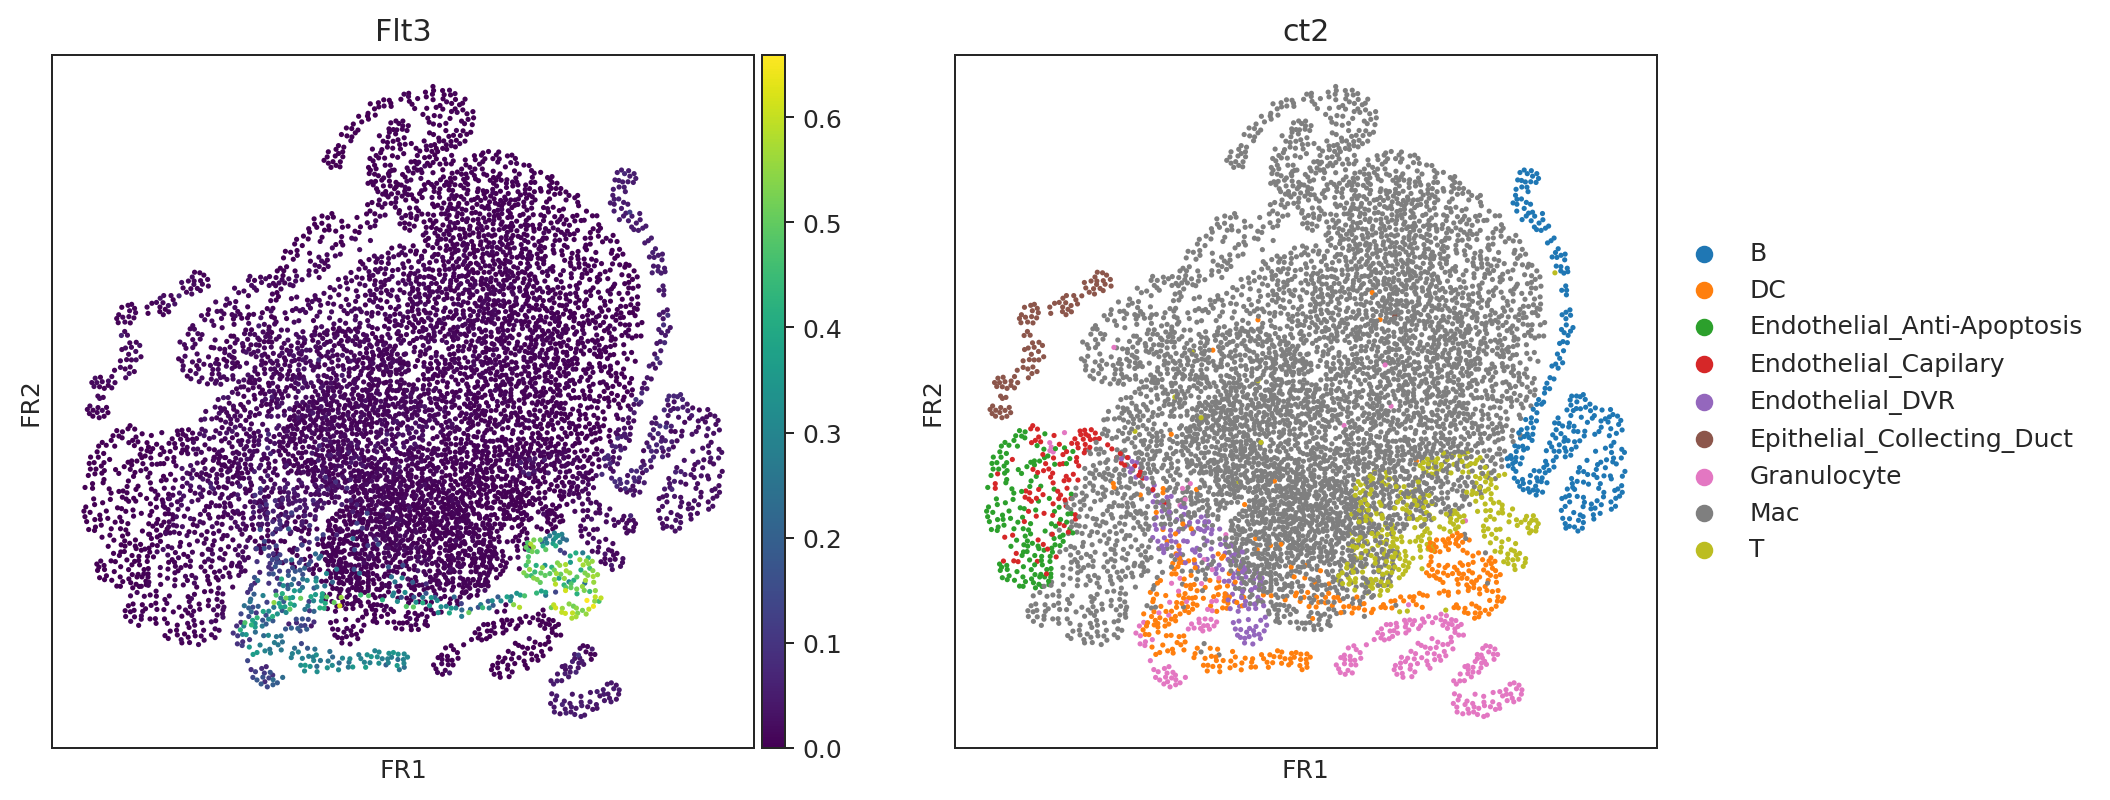

In [14]:
# Check gene expression
goi = "Flt3"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

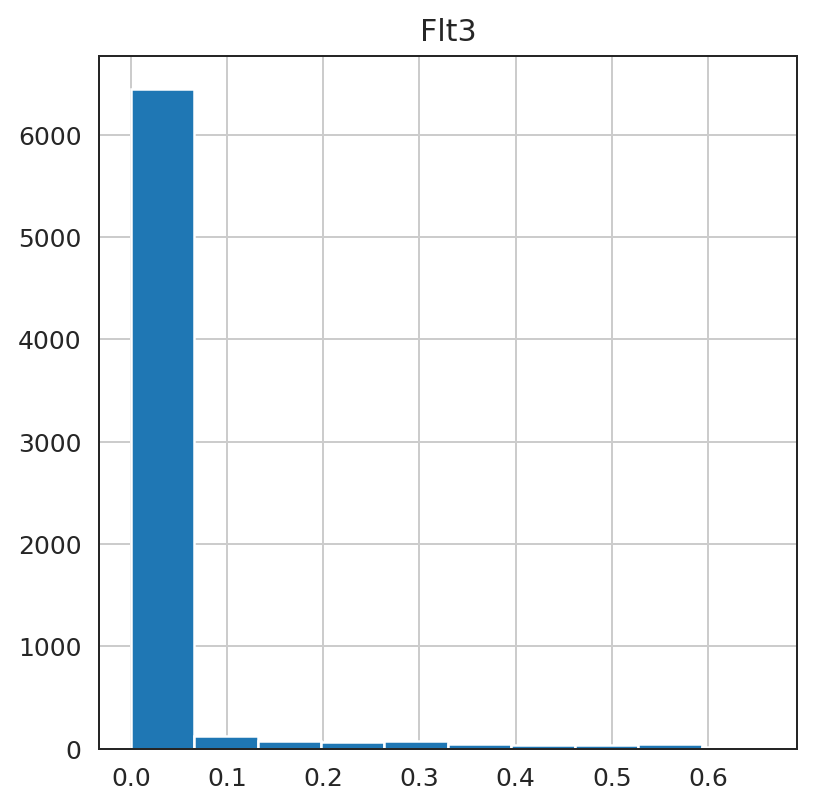

In [15]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [16]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [ ]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
min_mass = 0.01
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
save_dir = '/ix/djishnu/shared/djishnu_kor11/results/survey_kidney'

pythia = Prophet(
    adata=oracle.adata, # adata contains oracle shifts
    models_dir='/ix/djishnu/shared/djishnu_kor11/models_kidney',
    annot='cluster_cat',
    annot_labels='ct2'
)

In [ ]:
pythia.plot_contour_shift()